# Базовое решение задачи оценки качества изображений

В силу естественных причин, изображения, получаемые с фото/видео устройств, подвержены искажениям. Это может быть связано с условиями освещения, с движением во время съемки, несовершенствам параметров камеры и т.п. Все это влияет на качество получаемого изображения.

Оценка качества изображений (Image quality assessment, IQA) играет важную роль в различных приложениях обработки изображений. Она может использоваться, например, для таких целей как:
- выбор кадра наилучшего качества среди множества схожих кадров
- помощь в подстроении параметров камеры для получения изображений/видео более хорошего качества
- чистка датасета: имея датасет изображений, оценить качество всех входящих в него картинок и удалить из него самые плохие по качеству
- улучшение качества изображения (может использоваться в качестве метрики оценки качества работы алгоритма улучшения изображений, т.н. image enhancement) и т.п.

Первый приходящий в голову способ решить все вышеперечисленные задачи $-$ это задействовать живого человека, чтобы он мог взглянуть своими глазами и оценить качество картинки вручную. Потому что в большинстве случаев человеческий глаз и является "конечным пользователем" алгоритмов, связанных с качеством изображений. Это довольно субъективно, поэтому обычно используется усредненная оценка, составленная из мнений разных людей. Т.н. MOS (Mean Opinion Score). К сожалению, этот метод является довольно медленным, трудозатратным и дорогим. Поэтому и возникает острая потребность к автоматическом алгоритму IQA.

В большинстве задач используется не абсолютное понятие качества, а относительное (т.е. картинки сравниваются друг с другом). Существуют метрики оценки качества, задействующие референсное изображение (эталон). Одним из таких методов является PSNR (Peak Signal to Noise Ratio, https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio). Минусом таких метрик является то, что в реальной жизни референсы обычно не доступны. Преимуществом $-$ то, что они объективны.

## Данные

### О датасете и таргете

Датасет состоит из 16.5K искаженных изображений, соответствующих 3K референсным изображениям. Все изображения хранятся в формате png. Датасет уже поделен на train и test. Файлы именуются так: RR_D.png, где RR - номер соответствующего референса (сами референсы в датасет не включены), D - тип искажения. Всего используется 5 типов искажений, таких как размытие по Гауссу, сжатие, линейное преобразование, аддитивный гауссовский шум (поканально и в компоненте яркости).

Файл train.csv содержит PSNR для всех искаженных картинок. Чем ниже эта метрика, тем хуже картинка относительно рефересна.

В задании требуется предсказать PSNR (не имея референса).

Примеры картинок из датасета ниже:

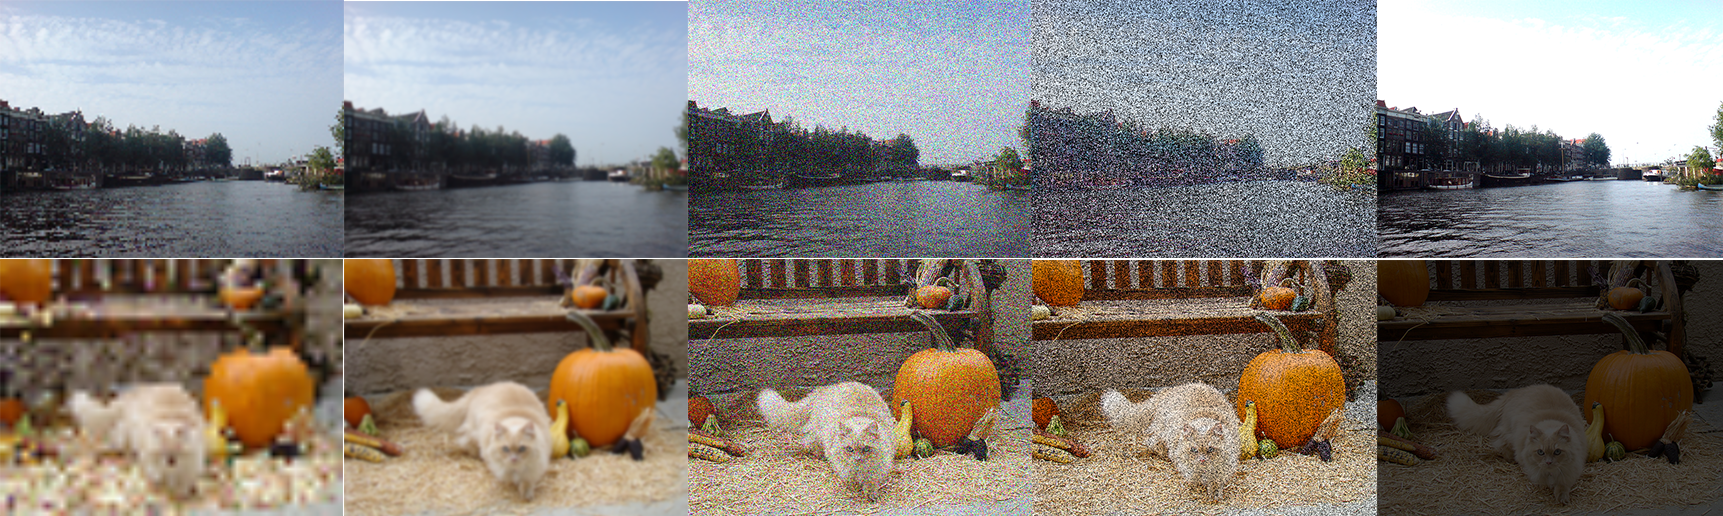

### Загрузка исходных данных

In [1]:
import os
from glob import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

Если у вас есть возможность, то лучше скачайте эту тетрадку и датасет и работайте локально. Данные содержат картинки, поэтому они много весят (8-9 Гб). Colab их грузит медленно, а если сессия долго не активна, то он прерывает работу, и придется все заново грузить. 

Если такой возможности нет, то наберитесь терпения :)
В случае работы в colab, данные можно подгрузить через shared drive

Я из соображений оперативности для разбора буду использовать маленькую часть датасета (mini_SBC22_IQA_dataset).

**Гайд, как подключить гугл диск с датасетом к colab по ссылке, не скачивая его к себе на диск.**

1. Перейдите по ссылке https://drive.google.com/drive/folders/1YPGf5YBelXyZJexvJQmjOxCpKDJkBFf3?usp=sharing
2. Нажмите на название папки (SBC22_IQA_dataset)
3. В выплавающем меню нажмите Add shortcut to Drive -> My Drive
4. В следующем окошке нажмите на иконку папки с плюсиком слева снизу и создайте папку в удобном месте на диске.
5. Выделите эту папку и нажмите ADD SHORTCUT
6. Все, теперь эта папка доступна из colab!
7. Далее, как обычно подмонтруйте свой диск (ячейка с кодом ниже)
8. В дереве файлов в меню слева найдите добавленную папку
9. Скопируйте путь к этой папке: правый клик -> Скопировать путь

In [2]:
# Монтирование в облачное хранилище Colab 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
src_path = "/content/gdrive/MyDrive/samsung/mini_SBC22_IQA_dataset"  # Здесь укажите путь до вашей папки (локальной, если вы работаете локально или на гугл диске, если в colab (см гайд))

path_2_train_csv = os.path.join(src_path, 'train.csv')
train_df = pd.read_csv(path_2_train_csv)

In [4]:
imgs = []
for img_name in tqdm(train_df.img_name.values, total=len(train_df)):
    img = cv2.imread(os.path.join(src_path, 'train', img_name))
    imgs.append(img)

  0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
imgs = np.array(imgs)

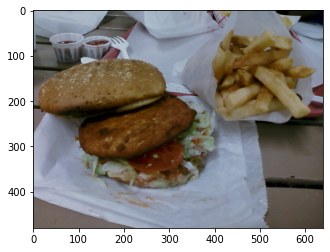

In [6]:
# Посмотрим пример картинки из датасета, который мы загрузили
ind = np.random.randint(0, len(imgs))
plt.imshow(cv2.cvtColor(imgs[ind], cv2.COLOR_BGR2RGB))
plt.show()

Теперь, так как таргет тестового датасета доступен только проверяющим, нам надо разбить обучающую выборку на train и val. И по валидационной выборке выбирать лучшую модель (либо использовать кросс валидацию). В нашем примере будет обычная валидация. Причем разбиение лучше делать с учетом референсных картинок, чтобы избежать зависимости между обучающей и валидационной выборками.

In [7]:
# Получение названий референсных картинок
ref_names = set()
for img_name in train_df.img_name.values:
    ref_names.add(img_name.split('_')[0])
ref_names = sorted(list(ref_names))
random.seed(7)
random.shuffle(ref_names)

In [8]:
# Деление на train и val
train_size = 0.8

train_names = []
train_ids = []
val_names = []
val_ids = []
for i, img_name in enumerate(train_df.img_name.values):
    ref = img_name.split('_')[0]
    if ref in ref_names[:int(train_size * len(ref_names))]:
        train_names.append(img_name)
        train_ids.append(i)
    else:
        val_names.append(img_name)
        val_ids.append(i)
print(f"Train size: {len(train_names)}")
print(f"Validation size: {len(val_names)}")

Train size: 20
Validation size: 5


In [9]:
tr_df = train_df.set_index('img_name').loc[train_names]
val_df = train_df.set_index('img_name').loc[val_names]


### Получение признаков

Бывают случаи, когда нужно работать не над самой моделью, а над признаками (фичами), которые в нее подаются. И если признаки достаточно хорошие и подходящие под задачу, то модель может быть совершенно простой и при этом работать. Попробуйте подступить к данной задаче именно с этой точки зрения.

In [10]:
# Для бейзлайна посчитаем всего 2 признака: яркость и резкость изображений. Резкость можно считать разными способами, здесь один из них
from scipy.stats import multivariate_normal


def brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2].mean()
    return v / 255 # normalization

def sharpness_grad_based(img):
    gradx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    grady = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    grad = np.sqrt(gradx * gradx + grady * grady)
    return grad[1: -1, 1: -1].mean()

def get_iqa_fv(img):
    fv = np.empty((0,))
    fv = np.append(fv, brightness(img))
    fv = np.append(fv, sharpness_grad_based(img))
    # ...your features here...
    return fv

def get_features(list_of_imgs):
    features =[]
    for img in tqdm(list_of_imgs):
        features.append(get_iqa_fv(img))
    features = np.vstack(list(features))
    return features

In [11]:
print('Подсчет признаков обучающей выборки...')
X_train = get_features(imgs[train_ids])
print('Подсчет признаков валидационной выборки...')
X_val = get_features(imgs[val_ids])
X_train.shape, X_val.shape

Подсчет признаков обучающей выборки...


  0%|          | 0/20 [00:00<?, ?it/s]

Подсчет признаков валидационной выборки...


  0%|          | 0/5 [00:00<?, ?it/s]

((20, 2), (5, 2))

### Нормализация данных

Для улучшения качества модели данные можно нормализовать. Таргеты можно привести к диапазону от 0 до 1, признаки можно стандартизовать. Если делать какие то манипуляции с данными, необходимо не забывать  сделать то же самое с тестовой выборкой. При манипуляции с таргетом необходимо в конце сделать обратное преобразование предсказаний (потому что проверяющая система ничего не знает о ваших методах нормализации).

In [12]:
y_train = tr_df.PSNR.values
y_val = val_df.PSNR.values

# Здесь можно нормализовать данные (опционально)
# X_train = ...
# X_Val = ...

## Обучение и тестирование модели

Как уже было сказано выше, если признаки хорошие, то, возможно, даже самая простая модель справится. Возьмем линейную регрессию.

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [14]:
# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()

In [15]:
# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_val, y_pred)} \nMAE = {mae(y_val, y_pred)}")

MSE = 5.766299649175204 
MAE = 2.057988429588754


Анализировать mse и mae в данном случае не очень удобно, так как таргет находится в странном диапазоне. Поэтому рекомендую обратить внимание на пункт "нормализация данных".

## Подготовка ответов

In [16]:
path_2_test_csv = os.path.join(src_path, 'sample_submission.csv') # В sample_submission хранятся имена файлов тестовой выборки
test_df = pd.read_csv(path_2_test_csv)

In [17]:
# Загрузка тестовой выборки
test_imgs = []
for img_name in tqdm(test_df.img_name.values, total=len(test_df)):
    img = cv2.imread(os.path.join(src_path, 'test', img_name))
    test_imgs.append(img)

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
# генерация фичей
print('Подсчет признаков тестовой выборки...')
X_test = get_features(test_imgs)

# нормализация/стандартизация, если нужна
# <ваш код>

y_pred = model.predict(X_test)

# обратная нормализация стандартизация, если нужна

Подсчет признаков тестовой выборки...


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
import pandas as pd

# Сохранение результатов
ans = pd.DataFrame({'img_name': test_df.img_name.values, 'PSNR': y_pred})
ans.to_csv('test.csv', index=False)

In [20]:
ans.head()

,img_name,PSNR
0,100090_1.png,30.188135
1,100090_2.png,28.799702
2,100090_3.png,26.736329
3,100090_4.png,28.793854
4,100090_5.png,30.125506


# Подсказки и советы по улучшению



*   Самое основное, что можно сделать - это добавить новых признаков. Посмотрите на датасет. Как вы думаете, какими признаками выделяются картинки очень плохого качества (разные признаки могут отвечать за разные типы  искажений). Попробуйте добавить насыщенность, экспозицию, контраст изображения. Можно еще придумать что-нибудь с балансом цвета, и проч.
* Можно использовать не только сами признаки, но и их квадраты и произведения (или другие нелинейные функции от них)
* Можно подбирать параметры линейной регрессии. Можно добавить регуляризацию
* Можно использовать другие модели, например, бустинг или случайный лес
* В конце, перед сабмитом, выбранную модель можно переобучить заново на всем тренировочном датасете (без выделения валидационной подвыборки)



